In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline


## Importación Dataset

In [2]:
df = pd.read_csv('properatti.csv', index_col = 0) ### Dataset Completo
## DataFrame Partido en distintas partes relevantes
df_posicion_geografica = df.loc[:,['place_name','state_name','country_name','place_with_parent_names' \
                                   ,'geonames_id','lat','lon','lat-lon', \
                                   'describe','title']] ### Parte con Posición Geográfica
df_localidad=df.loc[:,['place_name','place_with_parent_names','describe','title']] ## Parte con Localidades
df_ambientes = df.loc[:,['rooms','property_type','description','title']]  ## Parte con Ambientes
df_pisos = df.loc[:,['floor','property_type','description','title']]  ## Parte con Pisos
df_precio = df.loc[:,['price','currency','price_aprox_local_currency','price_aprox_usd',\
                      'surface_total_in_m2','surface_covered_in_m2','price_usd_per_m2',\
                      'price_per_m2','description','title']]  ## Parte con Precios y Superficies

C:\Users\zelru\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


## Funciones

In [3]:
def update(df,column,s):
    '''
    Reemplaza los valores de la columna del DataFrame con
    los valores no nulos de la serie
    '''
    df[column]=s.fillna(df[column])
    return df

def busqueda_ambientes(x):
    '''
    Busca la palabra amb (de ambientes) y devuelve el número que tiene por delante
    '''
    try:
        pattern = '(\d+)\s*amb'
        regex = re.compile(pattern, flags = re.IGNORECASE | re.UNICODE)
        m = regex.search(x)
        if m:
            return float(m.group(1))
        else:
            return np.NaN
    except:
        return np.NaN

def busqueda_monoambientes(x):
    '''
    Busca en la palabra monoambiente y devuelve 1
    '''
    if type(x) is str:
        if x.lower().find('monoambiente') >-1:
            return 1

def busqueda_moneda(x):
    try:
        pattern = 'U\$D\s*([\d\.]+)'
        regex = re.compile(pattern, flags = re.IGNORECASE | re.UNICODE)
        m = regex.search(x)
        if m:
            return float(m.group(1).replace('.',''))
        else:
            np.NaN
    except:
        return np.NaN
    
def parsear_numeros(x):
    '''
    Reemplaza numeros escritos en letras por sus equivalentes
    en arábigos.
    '''
    try:
        numeros={'uno':1,'un':1,'una':1,'dos':2,'tres':3,'cuatro':4,'cinco':5,'seis':6,'siete':7,'ocho':8,'nueve':9,'diez':10}
        for key in numeros:
            x = x.lower()
            x=x.replace(key,str(numeros[key]))
        return x
    except:
        return x

def busqueda_por_texto(x):
    '''
    Busca palabras claves asociadas a ambientes, como dormitorio, comedor, living, etc.
    y devuelve el número de veces que estas aparecen.
    '''
    result = 0.0
    valor = 0.0
    try:
        pattern = r"(\d*\s*living\s*cocina\s*comedor|living\s*comedor|living)|(\d*\s*dormitorio)|(\d*\s*comedor)"
        regex = re.compile(pattern, flags = re.IGNORECASE | re.UNICODE)
        grupos = regex.findall(x)
        for grupo in grupos:
            for elemento in grupo:
                regex_dos = re.compile(r'(\d+)', flags = re.IGNORECASE | re.UNICODE)
                cantidad = regex_dos.search(elemento)
                if cantidad is not None:
                    valor+=float(cantidad.group())
            if result == valor:
                result+=1
                valor+=1
            else:
                result=valor
        if result > 0.0:
            return result
        else:
            return np.NaN
    except:
        return np.NaN
def convert_to_int(x):
    return int(x)

## Breve Descripción del Dataset

In [4]:
df.head()

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447,...,35.0,1828.571429,1828.571429,NaN,NaN,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...


In [5]:
df.describe()

,geonames_id,lat,lon,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses
count,1.025030e+05,69670.000000,69670.000000,1.008100e+05,1.008100e+05,1.008100e+05,81892.000000,101313.000000,68617.000000,8.765800e+04,7899.000000,47390.000000,1.426200e+04
mean,3.574442e+06,-34.626210,-59.266290,4.685259e+05,4.229397e+06,2.397006e+05,233.795328,133.050181,2160.086916,6.912216e+03,17.452336,3.080840,5.009234e+03
std,3.541306e+05,1.980936,2.299922,2.260101e+06,6.904714e+06,3.913239e+05,1782.222147,724.351479,2759.288621,2.837864e+04,120.243621,1.860773,1.204403e+05
min,3.427208e+06,-54.823985,-75.678931,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.600000,1.510204e+00,1.000000,1.000000,1.000000e+00
25%,3.430234e+06,-34.669065,-58.727040,1.100000e+05,1.583309e+06,8.973388e+04,50.000000,45.000000,1218.181818,1.550000e+03,1.000000,2.000000,1.000000e+03
50%,3.433910e+06,-34.597985,-58.480128,1.850000e+05,2.558452e+06,1.450000e+05,84.000000,75.000000,1800.000000,2.213115e+03,3.000000,3.000000,2.000000e+03
75%,3.836668e+06,-34.441299,-58.395908,4.200000e+05,4.675792e+06,2.650000e+05,200.000000,150.000000,2486.411765,3.355549e+03,6.000000,4.000000,4.000000e+03
max,6.948895e+06,4.545843,-53.733330,6.500000e+08,8.212711e+08,4.654544e+07,200000.000000,187000.000000,206333.333333,4.000000e+06,3150.000000,32.000000,1.000150e+07


In [6]:
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121220 entries, 0 to 121219
Data columns (total 25 columns):
operation                     121220 non-null object
property_type                 121220 non-null object
place_name                    121197 non-null object
place_with_parent_names       121220 non-null object
country_name                  121220 non-null object
state_name                    121220 non-null object
geonames_id                   102503 non-null float64
lat-lon                       69670 non-null object
lat                           69670 non-null float64
lon                           69670 non-null float64
price                         100810 non-null float64
currency                      100809 non-null object
price_aprox_local_currency    100810 non-null float64
price_aprox_usd               100810 non-null float64
surface_total_in_m2           81892 non-null float64
surface_covered_in_m2         101313 non-null float64
price_usd_per_m2              68617 n

In [7]:
df.isnull().sum()

operation                          0
property_type                      0
place_name                        23
place_with_parent_names            0
country_name                       0
state_name                         0
geonames_id                    18717
lat-lon                        51550
lat                            51550
lon                            51550
price                          20410
currency                       20411
price_aprox_local_currency     20410
price_aprox_usd                20410
surface_total_in_m2            39328
surface_covered_in_m2          19907
price_usd_per_m2               52603
price_per_m2                   33562
floor                         113321
rooms                          73830
expenses                      106958
properati_url                      0
description                        2
title                              0
image_thumbnail                 3112
dtype: int64

In [8]:
df.loc[(~df.price.isnull()) & (df.currency.isnull())].properati_url
##la fila que tiene el precio pero no tiene currency es la 9761, El precio esta en 0.


9761    http://www.properati.com.ar/165i3_venta_casa_c...
Name: properati_url, dtype: object

# Parte Ambientes

* Descripción

In [9]:
df_ambientes.head()

,rooms,property_type,description,title
0,NaN,PH,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB
1,NaN,apartment,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...
2,NaN,apartment,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO
3,NaN,PH,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado
4,NaN,apartment,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...


In [10]:
df_ambientes.describe()

,rooms
count,47390.000000
mean,3.080840
std,1.860773
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,32.000000


In [11]:
df_ambientes.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121220 entries, 0 to 121219
Data columns (total 4 columns):
rooms            47390 non-null float64
property_type    121220 non-null object
description      121218 non-null object
title            121220 non-null object
dtypes: float64(1), object(3)
memory usage: 4.6+ MB


In [12]:
df_ambientes.isnull().sum()

rooms            73830
property_type        0
description          2
title                0
dtype: int64

* Limpieza de Datos

In [13]:
df_ambientes[(df_ambientes.property_type =='apartment') & (~df_ambientes.rooms.isnull())].iloc[0,2]

' Torre I Mondrian. 3 ambientes con terraza y dos baños al frente.Vitraux ofrece en el ultimo nivel, Piscina con Solarium, un espacio con Sala de Reunión para uso profesional, eventos o proyecciones con un amplio Foyer, Sauna, Gimnasio, un Salón de Usos Múltiples con cocina y una amplia expansión. Asimismo cuenta con un Hall en Doble altura y un amplio Estar que balconea al mismo en el primer piso.Así destaca la Excelente Relación de espacios de uso común sobre el metro propio, sobre todo en Studios que rondan los 30 metros propios y pueden gozar de todos los diferentes usos especiales.'

In [14]:
df_ambientes_nulos=df_ambientes[df_ambientes.rooms.isnull()] ## Nos quedamos solo con los elementos nulos

In [15]:
df_ambientes.description=df_ambientes.description.apply(parsear_numeros)## Reemplaza los números escritos en letras por los arábigos

In [16]:
df_ambientes = update(df_ambientes,'rooms',df_ambientes.description.apply(busqueda_por_texto))
df_ambientes.isnull().sum()
#df_ambientes_nulos.rooms.fillna(df_ambientes_nulos.description.apply(busqueda_por_texto),inplace=True)

rooms            21099
property_type        0
description          2
title                0
dtype: int64

In [17]:
df_ambientes = update(df_ambientes,'rooms',df_ambientes.description.apply(busqueda_ambientes))
df_ambientes = update(df_ambientes,'rooms',df_ambientes.title.apply(busqueda_ambientes))
#df_ambientes.rooms.fillna(df_ambientes.description.apply(busqueda_ambientes),inplace=True)
#df_ambientes.rooms.fillna(df_ambientes.title.apply(busqueda_ambientes),inplace=True)
## Rellena los Ambientes vacíos en base a la cantidad de ambientes dichas en la descripción
df_ambientes.isnull().sum()

rooms            14263
property_type        0
description          2
title                0
dtype: int64

In [18]:
df_ambientes = update(df_ambientes,'rooms',df_ambientes.description.apply(busqueda_monoambientes))
df_ambientes = update(df_ambientes,'rooms',df_ambientes.title.apply(busqueda_monoambientes))
#df_ambientes.rooms.fillna(df_ambientes.description.apply(busqueda_monoambientes),inplace=True)
#df_ambientes.rooms.fillna(df_ambientes.title.apply(busqueda_monoambientes),inplace=True)
## Rellena los Ambientes vacíos en base a si es un monoambiente o no (presente en la descripción)
df_ambientes.isnull().sum()

rooms            11985
property_type        0
description          2
title                0
dtype: int64

In [19]:
df_ambientes.isnull().sum()

rooms            11985
property_type        0
description          2
title                0
dtype: int64

In [20]:
df_ambientes.rooms = df_ambientes.rooms.apply(lambda x: 0 if np.isnan(x) else int(x))

In [21]:
x=24
df_ambientes.iloc[x,1],df_ambientes.iloc[x,0],df_ambientes.iloc[x,2],df_ambientes.iloc[x,3]## Estado de los Ambientes al presente

('apartment',
 4,
 'exclusivo  departamento de excelente categoria en venta en castelar160 mts2  cubiertos.  4 ambientes con balcón terraza, parrilla y cochera. entrega marzo 2018.el precio publicado corresponde al valor de contado  para las 1idades de primer y seg1do piso. financiacion: anticipo usd71.000, usd 105.000 a la escritura y el resto financiado en 36 cuotas (con refuerzos semestrales) valor financiado usd 380.940piso con palier privado con puerta de seguridad  y entrada de servicio. linving comedor , 3 dormitorios 1 de los cuales es en suite  con ducha escocesa, con vestidor. otros 2 dormitorios con placars  que comparten 1 baño completo con bañera.  pisos de madera en dormitorios y living comedor, pisos de porcelanato en pasillos y cocina. ventanas de aluminio con dvh (doble vidrio hermético) en todo el depto. cocina completa (con cocina vitroceramica, horno eléctrico, microondas, heladera con frezzer, cafetera express to2 marca bgh),  despensa y lavadero. toilete, balcón t

In [22]:
df_ambientes.iloc[12,2]

'excelente departamento 2 ambientes contrafrente con balcon a pulmon de manzana.a solo media cuadra de la av. santa fe.living                   3,06 x 5,30 dormitorio          2,80 x 3,60     baño                     1,55 x 2,11     cocina                  1,60 x 3,13    balcon                  4,61 x 1 posee 2 aires acondiciona2 nuevos.terraza.total cubiertos: 35,66semi  3,56total: 39,22     aviso publicado por pixel inmobiliario (servicio de páginas web para inmobiliarias).'

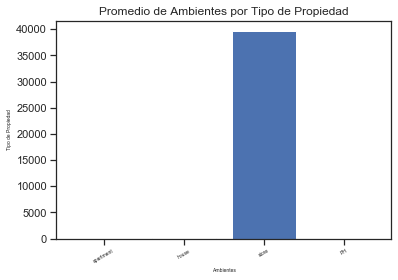

In [82]:
def cust_mean(grp):
    grp['mean'] = grp['option_value'].mean()
    return grp

#objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
#y_pos = np.arange(len(df_ambientes.property_type))

df_ambientes_mean =df_ambientes.groupby('property_type').mean()
property_type = list(set(df_ambientes.property_type))
valores=list(df_ambientes_mean.rooms)

index = np.arange(len(property_type))
plt.bar(index, valores)
plt.xlabel('Ambientes', fontsize=5)
plt.ylabel('Tipo de Propiedad', fontsize=5)
plt.xticks(index, property_type, fontsize=5, rotation=30)
plt.title('Promedio de Ambientes por Tipo de Propiedad')
plt.show()
## Hay un problema en la data

#plt.show()

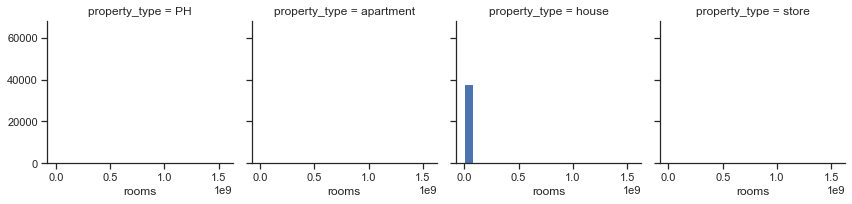

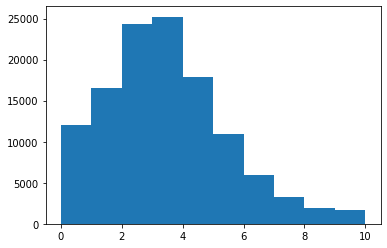

In [24]:
fig, ax = plt.subplots()
ax.hist(df_ambientes.rooms,bins=range(11))
ax.ticklabel_format(useOffset=False, style='plain')
plt.show()



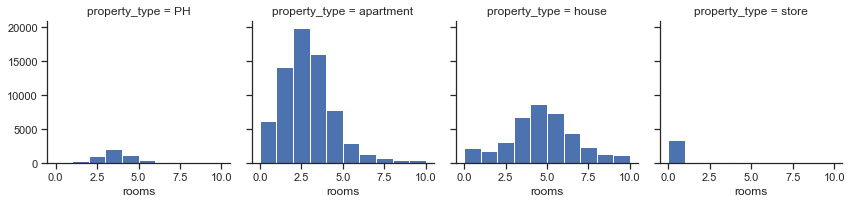

In [29]:
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(df_ambientes, col="property_type")
g = g.map(plt.hist, "rooms",bins=range(11))